# Building Explainable Machine Learning Models
## Exercise: Interpreting models with SHAP

* SHAP stands for SHapley Additive exPlanations.
* It leverages the concept of game theory to break down a prediction to measure the impact of each feature.
* Shap displays the effect of the feature at on prediction at a certain value than if the feature was at a baseline value.


During this exercise,  you are going to be working with SHAP (SHapley Additive exPlanations)by working on a credit card dataset. You'll perform the following steps:

* Train a Random Forest model on the given dataset.
* Compute the Shapley values  to explain the individual feature contributions.
* Visualize these values and interpret them.


Let's get started!

---

## Case Study

### Predicting if income exceeds $50,000 per year based on 1994 US Census Data 

 The Adult Income dataset, also known as the "Census Income" dataset, contains a variety of attributes or features that describe individuals in the dataset. The target variable is True if a person earns more than `$50K` annually and False if the earned income is ≤ $50K. The attributes of our dataset (preprocessed version) include:

* **Age** : the age of the individual
* **Workclass** : the type of employment the individual has (e.g. private, government, self-employed)
* **Education** : the level of education the individual has achieved (e.g. high school, college, graduate degree)
* **Marital-status** : the individual's marital status (e.g. married, divorced, single)
* **Occupation** : the type of work the individual is employed in (e.g. sales, management, craft-repair)
* **Race** : the individual's race (e.g. White, Black, Asian)
* **Sex** : the individual's gender (e.g. Male, Female)
* **Hours-per-week** : the number of hours the individual works per week
* **Income** : the individual's income level (either <=50K or >50K)


<div class="alert alert-block alert-danger">


Note that the attributes might be different based on the source of the dataset and the version you are using.Also this dataset reflects bias and imbalance w.r.t gender and race. Be careful when using such datasets. In this notebook this dataset is only used for demo purposes.




## Importing Necessary Libraries

Let’s start by importing the necessary libraries.

In [22]:
#%pip install shap -qq
#%pip install numpy==1.20 # Numba requires numpy 1.21 or less


import numpy as np   
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

np.random.seed(123) #ensure reproducibility
RANDOM_STATE = 42

## Model Interpretation package
import shap
shap.initjs()

import warnings  
warnings.filterwarnings(action = "ignore")

In [23]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(10,6)})

##  Reading in the Dataset



In [24]:
data= pd.read_csv('../data/Adult Income Dataset.csv')
data.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   education       26048 non-null  object
 3   marital_status  26048 non-null  object
 4   occupation      26048 non-null  object
 5   race            26048 non-null  object
 6   gender          26048 non-null  object
 7   hours_per_week  26048 non-null  int64 
 8   income          26048 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1.8+ MB


In [26]:
# Inspecting Distribution of Target Variable

data['income'].value_counts()

0    19820
1     6228
Name: income, dtype: int64

# Data Preparation 




## Train/Test Split
Splitting the dataset into traininga and validation dataset.



In [27]:
# Creating the target and the features column and splitting the dataset into test and train set.
  
X = data.iloc[:, :-1]  
y = data.iloc[:, -1]  
  
# splitting the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)



## Encoding the categorical features

We'll leave the numerical features as-is and only encode the categorical features using a OrdinalEncoder.

In [28]:
numerical_features = [
    "age",
    "hours_per_week"]

categorical_features = X_train.columns.drop(numerical_features)
categorical_features

Index(['workclass', 'education', 'marital_status', 'occupation', 'race',
       'gender'],
      dtype='object')

In [29]:
encoder = OrdinalEncoder()
X_train_categorical_data = X_train[categorical_features]
X_train_encoded = encoder.fit_transform(X_train_categorical_data)
X_train_encoded[:5]

    


array([[2., 7., 3., 5., 0., 0.],
       [2., 3., 1., 0., 1., 1.],
       [2., 7., 1., 5., 0., 0.],
       [2., 6., 3., 4., 1., 0.],
       [2., 1., 3., 2., 1., 1.]])

In [30]:
encoder.categories_

[array(['Government', 'Other/Unknown', 'Private', 'Self-Employed'],
       dtype=object),
 array(['Assoc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters',
        'Prof-school', 'School', 'Some-college'], dtype=object),
 array(['Divorced', 'Married', 'Separated', 'Single', 'Widowed'],
       dtype=object),
 array(['Blue-Collar', 'Other/Unknown', 'Professional', 'Sales', 'Service',
        'White-Collar'], dtype=object),
 array(['Other', 'White'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [31]:
class_names =  np.array([0,1])

## Preprocessed Training Set

In [32]:
X_train_encoded_df = pd.DataFrame(X_train_encoded,columns = categorical_features, index = X_train.index)
X_train_preprocessed = pd.concat([X_train_encoded_df,X_train[numerical_features]],axis=1)
X_train_preprocessed

,workclass,education,marital_status,occupation,race,gender,age,hours_per_week
9184,2.0,7.0,3.0,5.0,0.0,0.0,24,25
448,2.0,3.0,1.0,0.0,1.0,1.0,39,40
9013,2.0,7.0,1.0,5.0,0.0,0.0,24,45
14986,2.0,6.0,3.0,4.0,1.0,0.0,22,30
25531,2.0,1.0,3.0,2.0,1.0,1.0,30,50
...,...,...,...,...,...,...,...,...
13123,3.0,0.0,3.0,0.0,1.0,1.0,34,40
19648,2.0,1.0,3.0,2.0,1.0,1.0,37,40
9845,2.0,7.0,3.0,5.0,1.0,0.0,19,16
10799,2.0,3.0,1.0,0.0,1.0,1.0,29,45


## Preprocessing the test set

In [33]:

X_test_categorical_data = X_test[categorical_features]
X_test_encoded = encoder.transform(X_test_categorical_data)
X_test_encoded_df = pd.DataFrame(X_test_encoded,columns = categorical_features,index = X_test.index)
X_test_preprocessed = pd.concat([X_test_encoded_df,X_test[numerical_features]],axis=1)
X_test_preprocessed.head()



,workclass,education,marital_status,occupation,race,gender,age,hours_per_week
8771,2.0,7.0,3.0,0.0,1.0,1.0,22,25
13138,3.0,7.0,1.0,5.0,1.0,1.0,50,50
15380,2.0,7.0,3.0,0.0,1.0,0.0,22,30
15502,2.0,6.0,1.0,2.0,0.0,1.0,63,30
16555,2.0,6.0,0.0,0.0,1.0,1.0,31,40


# Training the classifier


Now you will fit a [Random Forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and compute the [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) achieved:

In [34]:
model = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=20)
model.fit(X_train_preprocessed, y_train)

RandomForestClassifier(max_depth=6, n_estimators=20, random_state=0)

In [35]:
model.score(X_test_preprocessed, y_test)

0.8115786240786241

In [36]:
# Making predictions on the test set
y_pred = model.predict_proba(X_test_preprocessed)[:, 1]

## Displaying Random Forests' Feature Importance

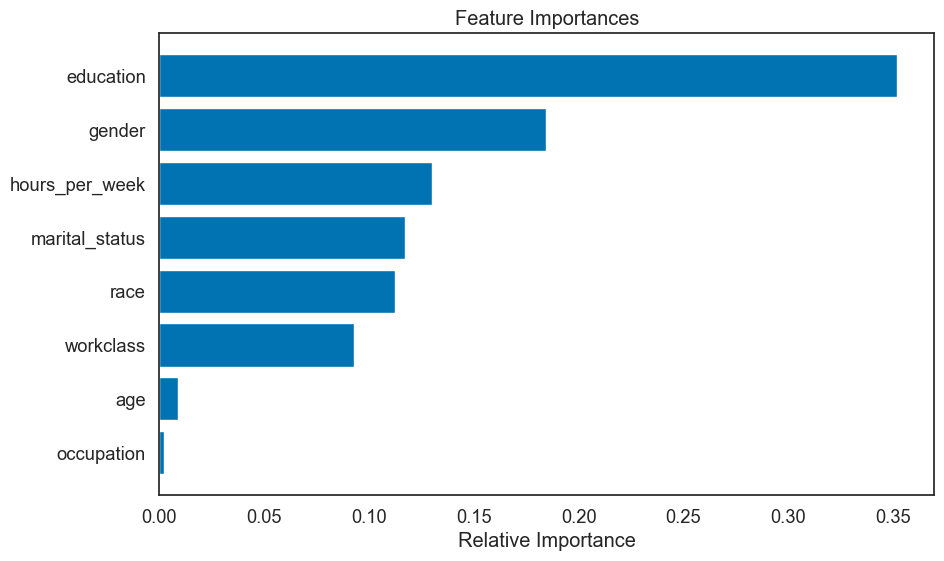

In [37]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We now have our model and our predictions. Let’s now explore the different ways by which we can understand the model and its predictions in a more meaningful way.

---

## Calculating SHAP values



![](https://imgur.com/qPBkX1r.png)

source: [Documentation of SHAP](https://github.com/slundberg/shap)

To get the importance of feature X<sub>i</sub>:

* Get all subsets of features that do not contain X<sub>i</sub>
* Compute effect on our predictions of adding X<sub>i</sub> to all those subsets
* Aggregate all contributions to compute the marginal contribution of the feature

### SHAP Tree explainer

To compute shap values for the model you just trained you will use the [TreeExplainer](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.TreeExplainer.html) class from the `shap` library. A SHAP tree explainer is a high-speed exact algorithm for tree ensemble methods that supports XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models. To instantiate this class you need to pass in a model.

In [38]:
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X_test_preprocessed)
pd.DataFrame(shap_values[1]).head()

,0,1,2,3,4,5,6,7
0,-0.001912,-0.011529,-0.088470,-0.025595,0.000264,0.012154,-0.072888,-0.039188
1,0.006427,-0.034904,0.102435,0.058653,0.000768,0.042750,0.056935,0.095668
2,-0.001792,-0.010484,-0.075919,-0.021875,0.000706,-0.028464,-0.062919,-0.031665
3,-0.005069,-0.022749,0.107074,0.103886,-0.004505,0.037670,0.056493,-0.076972
4,-0.003503,-0.026753,-0.022909,-0.059420,0.000902,0.020064,-0.028359,-0.021466


* We get a matrix of SHAP values. These values measure how and how much each feature impacts the model.





Tree SHAP provides us with several different types of plots, each one highlighting a specific aspect of the model. The available plots are:
* Summary plot
* Force plot
* Dependence plot
* Decision plot

### Force Plot - Visualize a single prediction

Predicting when a person’s income > $50K


In [39]:
classes = {0 : 'False', 1: 'True'}

y_pred = model.predict_proba(X_test_preprocessed)[:, 1]
classes[round(y_pred[25])]


'True'

In [40]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][25], X_test_preprocessed.iloc[25])

The base_value here is `0.2384`, while the target value for the selected sample is `0.53`. All the values greater than the base value will have income `≥ $50K` and vice versa. For the chosen sample, the features appearing in red in push the prediction toward the base value while those in blue push the prediction away from the base value. It is therefore possible to infer that being a HS grad negatively influences the model’s prediction for this particular person earning >$50K. 

### Summary plot

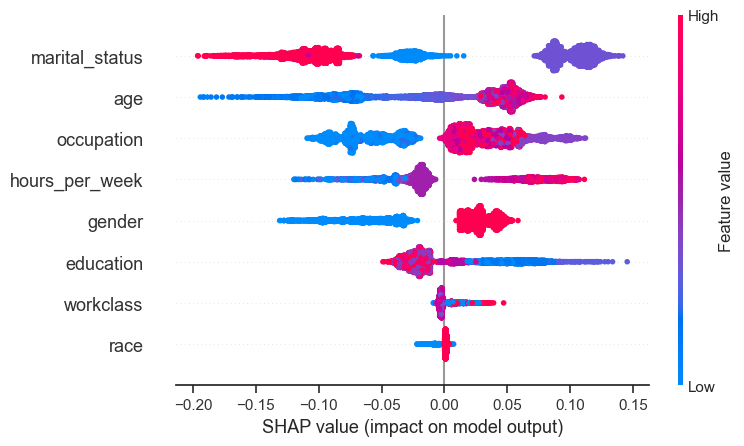

In [41]:
shap.summary_plot(shap_values[1], features=X_test_preprocessed, max_display=10)

Each point in Figure above represents a row from the original dataset. For every point:

* The y-axis indicates the features in order of importance from top to bottom. The x-axis refers to the actual SHAP values.
* The horizontal location of a point represents the feature’s impact on the model’s prediction for that particular sample.
* The color shows whether the value of a feature is high (red) or low (blue) for any row of the dataset.

From the summary plot, it is possible to infer that ‘Marital status’ and ‘Age’ have a higher total model impact on predicting whether a person will earn a higher income or not, as compared to other features.




### References

[1] https://en.wikipedia.org/wiki/Shapley_value

[2] https://github.com/slundberg/shap

[3] C. Molnar, [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book), 

---